<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/RECONOCIMIENTO-DE-FORMAS-Y-APRENDIZAJE-COMPUTACIONAL/blob/main/SEMANA%2013%20Y%2014%20%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMANA 13

### TEMA 5. MATERIALES Y TEXTURA.

5.4. Generación de texturas y aprendizaje profundo.

5.5. Transferencia de estilo en imágenes.

5.6. Aprendizaje profundo en la identificación de materiales con aplicaciones
prácticas en diseño gráfico y realidad virtual

El objetivo de la clase será comprender cómo los modelos de aprendizaje profundo generan, transforman y reconocen texturas y materiales, así como valorar sus aplicaciones en el diseño gráfico y la realidad virtual.


#SEMANA 14
###TEMA 5. MATERIALES Y TEXTURA.

5.7. Datasets y problemas específicos.

5.8. Técnicas de fusión de datos.

5.9. Aplicaciones prácticas.

5.10. Desafíos futuros.

Objetivo: Conocer los datasets clave y los retos del área, explorar fusión de datos y proyectar aplicaciones y tendencias.

In [ ]:
import os, glob, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# 🧾 2) Crear DataFrame con rutas y etiquetas
def list_images_with_labels(root, exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
    rows = []
    for cls in CLASSES:
        cls_dir = os.path.join(root, cls)
        for f in os.listdir(cls_dir):
            if f.lower().endswith(exts):
                rows.append({"path": os.path.join(cls_dir,f), "label": cls})
    return pd.DataFrame(rows)
# 🗃️ 5) tf.data datasets + opción de balanceo por oversampling

def load_image_from_numeric_label(path, y):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, tf.one_hot(tf.cast(y, tf.int32), depth=len(CLASSES))

def make_ds_numeric(df_subset, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((df_subset["path"].values, df_subset["y"].values))
    ds = ds.map(load_image_from_numeric_label, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_for_backbone(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Oversampling para balancear train
def balance_df(df_train):
    counts = df_train["label"].value_counts()
    mx = counts.max()
    parts = []
    rng = np.random.default_rng(42)
    for cls, sub in df_train.groupby("label"):
        idx = rng.choice(sub.index, size=mx, replace=True)
        parts.append(df_train.loc[idx])
    return pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)



In [ ]:
# ✅ Reemplazo seguro para construir datasets SIN dicts de Python dentro del graph

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobv2_pre

AUTOTUNE = tf.data.AUTOTUNE



# --- 2) Preprocess del backbone en el pipeline (evita Lambdas en el modelo)
def preprocess_for_backbone(img):
    img255 = img * 255.0
    if PIPE_BACKBONE == "resnet50":
        return resnet_pre(img255)
    else:
        return mobv2_pre(img255)


# --- 4) Cargador que usa la tabla de lookup (no dict de Python)
def load_image(path, label_str):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    label_id = label_table.lookup(tf.cast(label_str, tf.string))   # <-- CLAVE
    return img, tf.one_hot(label_id, depth=len(CLASSES))

def make_ds(df_subset, shuffle=True, augment=False, batch_size=32, repeat=False):
    ds = tf.data.Dataset.from_tensor_slices((df_subset["path"].values, df_subset["label"].values))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_for_backbone(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    if repeat:
        ds = ds.repeat()
    return ds

In [ ]:
def plot_history(h, title=""):
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.title(f"Accuracy {title}"); plt.xlabel("Epoch"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.title(f"Loss {title}"); plt.xlabel("Epoch"); plt.legend(); plt.show()

In [ ]:
import tensorflow as tf, numpy as np, cv2, matplotlib.pyplot as plt
from tensorflow import keras

def pick_cam_layer(model, preferred_names=()):
    """
    Devuelve la mejor capa conv para CAM:
    - si hay nombres preferidos (tuplas) y existen, usa la primera encontrada
    - si no, toma la última capa con salida 4D pero de mayor resolución posible
    """
    # 1) intenta por nombre preferido
    for name in preferred_names:
        try:
            lyr = model.get_layer(name)
            if len(lyr.output.shape) == 4:
                return name
        except Exception:
            pass
    # 2) busca la conv con mayor H×W posible (y 4D)
    best = None; best_hw = -1
    for layer in model.layers:
        try:
            shp = layer.output.shape
            if len(shp) == 4:
                hw = int(shp[1]) * int(shp[2])
                if hw > best_hw:
                    best_hw = hw
                    best = layer.name
        except Exception:
            continue
    if best is None:
        raise ValueError("No se encontró capa conv (salida 4D).")
    return best

def grad_cam_raw(model, img_tensor, layer_name):
    # img_tensor: (1,H,W,3) YA preprocesada
    conv_layer = model.get_layer(layer_name)
    grad_model = keras.Model(model.inputs, [conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]
    grads   = tape.gradient(loss, conv_out)               # (1,h,w,c)
    weights = tf.reduce_mean(grads, axis=(1,2), keepdims=True)   # (1,1,1,c)
    cam     = tf.reduce_sum(conv_out * weights, axis=-1)[0].numpy()  # (h,w)
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-9)
    return cam  # [0,1]

def unpreprocess_for_backbone(x, backbone="mobilenetv2"):
    x = np.array(x)
    if backbone.lower() == "mobilenetv2":
        x = (x + 1.0) * 127.5
        return np.clip(x, 0, 255).astype("uint8")
    elif backbone.lower() == "resnet50":
        MEAN_BGR = np.array([103.939, 116.779, 123.68], dtype=np.float32)
        bgr = x + MEAN_BGR
        bgr = np.clip(bgr, 0, 255).astype("uint8")
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        if x.max() <= 1.0: x = x * 255.0
        return np.clip(x, 0, 255).astype("uint8")

def overlay_heatmap_on_image(base_img_uint8, heatmap_01, alpha=0.35, blur_ks=11, cmap=cv2.COLORMAP_JET):
    H, W = base_img_uint8.shape[:2]
    heat = cv2.resize(heatmap_01, (W, H), interpolation=cv2.INTER_CUBIC)
    if blur_ks and blur_ks >= 3:
        heat = cv2.GaussianBlur(heat, (blur_ks, blur_ks), 0)  # suaviza bloques
    heat_u8   = np.uint8(255 * np.clip(heat, 0, 1))
    heat_bgr  = cv2.applyColorMap(heat_u8, cmap)
    heat_rgb  = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB)
    overlay   = cv2.addWeighted(base_img_uint8, 1.0, heat_rgb, alpha, 0)
    return heat, overlay

def show_gradcam_better(model, path, backbone="mobilenetv2",
                        preferred_layers=("block_13_expand_relu","block_14_expand_relu","Conv_1"),
                        alpha=0.35, blur_ks=11, as_gray=True, title="Grad-CAM"):
    # 1) imagen "limpia" para mostrar
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bicubic")
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    base_rgb = (img.numpy()*255).astype("uint8")
    if as_gray:
        base_rgb = cv2.cvtColor(cv2.cvtColor(base_rgb, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

    # 2) tensor preprocesado para el modelo
    x = tf.expand_dims(preprocess_for_backbone(img), 0)

    # 3) elige una capa conv con mayor resolución
    layer_name = pick_cam_layer(model, preferred_names=preferred_layers)

    # 4) grad-cam crudo y overlay
    cam = grad_cam_raw(model, x, layer_name)
    heat, overlay = overlay_heatmap_on_image(base_rgb, cam, alpha=alpha, blur_ks=blur_ks)

    # 5) mostrar
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(base_rgb); plt.title("Imagen"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cv2.resize(heat, (IMG_SIZE, IMG_SIZE)), cmap="jet"); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"{title} — {layer_name}"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
####borrar?

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras

def get_last_conv_name(model):
    # Devuelve el nombre de la última capa con salida 4D (B,H,W,C)
    for layer in reversed(model.layers):
        try:
            if len(layer.output.shape) == 4:
                return layer.name
        except Exception:
            pass
    raise ValueError("No se encontró una capa convolucional con salida 4D.")

def grad_cam_raw(model, img_tensor, class_index=None, layer_name=None):
    """
    Calcula el mapa Grad-CAM normalizado en [0,1] (sin colorear).
    - img_tensor: (1, H, W, 3), ya preprocesado para el backbone del modelo.
    """
    if layer_name is None:
        layer_name = get_last_conv_name(model)

    conv_layer = model.get_layer(layer_name)
    grad_model = keras.Model(model.inputs, [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)  # conv_out: (1,h,w,c)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    # Gradientes respecto a la activación
    grads = tape.gradient(loss, conv_out)  # (1,h,w,c)
    # Promedio global por canal
    weights = tf.reduce_mean(grads, axis=(1, 2))  # (1, c)
    # Pondera los mapas de activación por los pesos
    cam = tf.reduce_sum(tf.multiply(conv_out, tf.reshape(weights, (1,1,1,-1))), axis=-1)  # (1,h,w)
    cam = cam[0].numpy()

    # ReLU + normalización a [0,1]
    cam = np.maximum(cam, 0)
    cam /= (cam.max() + 1e-9)
    return cam  # (h, w) en [0,1]

def overlay_heatmap_on_image(base_img_uint8, heatmap_01, alpha=0.45, cmap=cv2.COLORMAP_JET):
    """
    Toma una imagen base (uint8, HxWx3) y un heatmap [0,1] (h*w),
    lo redimensiona, colorea y hace blend.
    """
    H, W = base_img_uint8.shape[:2]
    # Redimensionar heatmap al tamaño de la imagen
    heat_resized = cv2.resize(heatmap_01, (W, H), interpolation=cv2.INTER_CUBIC)
    # A colormap (uint8 0..255) -> BGR
    heat_uint8 = np.uint8(255 * heat_resized)
    heat_color = cv2.applyColorMap(heat_uint8, cmap)  # BGR
    # A RGB para matplotlib
    heat_rgb = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    # Blend
    over = cv2.addWeighted(base_img_uint8, 1.0, heat_rgb, alpha, 0)
    return over

def show_gradcam(model, path, alpha=0.45, title="Grad-CAM", as_gray=False):
    """
    Lee la imagen desde 'path', la muestra y superpone Grad-CAM.
    Usa el mismo preprocess del pipeline para 'x', pero visualiza la imagen 'limpia'.
    """
    # 1) Leer imagen "limpia" para visualización
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bicubic")
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    base = (img.numpy() * 255).astype("uint8")          # RGB uint8 para mostrar

    # Si deseas verla en escala de grises (útil en ecografías)
    if as_gray:
        gray = cv2.cvtColor(base, cv2.COLOR_RGB2GRAY)
        base = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # 2) Preprocesar para el backbone (no para visualizar)
    x = tf.expand_dims(preprocess_for_backbone(img), 0)  # (1,H,W,3)

    # 3) Grad-CAM crudo [0,1]
    heat = grad_cam_raw(model, x)

    # 4) Overlay
    overlay = overlay_heatmap_on_image(base, heat, alpha=alpha, cmap=cv2.COLORMAP_JET)

    # 5) Mostrar
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(base);    plt.title("Imagen");   plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(title);      plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
# 1) Ajusta build_model para recibir lr explícito
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV2

def build_model(backbone="resnet50", dropout=0.3, freeze=True, lr=1e-3):
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    if backbone == "resnet50":
        base = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")
    elif backbone == "mobilenetv2":
        base = MobileNetV2(include_top=False, input_tensor=inputs, weights="imagenet")
    else:
        raise ValueError("backbone debe ser 'resnet50' o 'mobilenetv2'.")

    if freeze:
        for l in base.layers:
            l.trainable = False

    x = base.outputs[0]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(len(CLASSES), activation="softmax")(x)
    model = keras.Model(inputs, out, name=f"{backbone}_clf")

    # Compilar con LR explícita (evita 'auto')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def unfreeze_last_n(model, n=40, lr=1e-4):
    count = 0
    for layer in reversed(model.layers):
        if isinstance(layer, layers.BatchNormalization):
            continue
        if hasattr(layer, "trainable"):
            layer.trainable = True
            count += 1
            if count >= n:
                break
    # recompila con la LR de fine-tuning
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="categororical_crossentropy" if False else "categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_drive_path = "/content/drive/MyDrive/A105 RECONOCIMIENTO DE FORMAS Y APRENDIZAJE COMPUTACIONAL /Clases/Semana 13/Oral Cancer.zip"
dataset_extract_path = "/content/"

# Crear carpeta de extracción
os.makedirs(dataset_extract_path, exist_ok=True)

# Descomprimir directamente desde Drive
with zipfile.ZipFile(zip_drive_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

print("Archivos extraídos en:", dataset_extract_path)
!ls "/content/Oral cancer"

Archivos extraídos en: /content/
ls: cannot access '/content/Oral cancer': No such file or directory


In [ ]:
# 📂 1) Rutas y librerías
import os, glob, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 👇 Ajusta al root de Oral Cancer (carpetas por clase adentro)
# Estructura esperada:
# /content/OralCancer/
#   classA/
#   classB/
#   ...
DATA_DIR = "/content/Oral Cancer"   # <-- AJUSTAR

IMG_SIZE = 160        # 224 para ResNet/MobileNet
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Descubrir clases por carpetas
CLASSES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR,d))])
assert len(CLASSES) >= 2, "Se requieren >=2 clases (subcarpetas)."
print("Clases:", CLASSES)


Clases: ['oral_normal', 'oral_scc']


# 🧩 1) Tabla de búsqueda de etiquetas (string → id numérico)

Las clases de nuestro dataset están representadas por nombres (por ejemplo: `"oral_normal, oral_scc"`).
Sin embargo, las redes neuronales no pueden trabajar directamente con cadenas de texto, por lo que necesitamos
asignar un **índice numérico** a cada clase.

Para hacerlo dentro del grafo de TensorFlow (y evitar errores con tensores tipo string),
usamos una **tabla de búsqueda (`tf.lookup.StaticHashTable`)**:

```python
label_keys = tf.constant(CLASSES, dtype=tf.string)
label_vals = tf.range(len(CLASSES), dtype=tf.int32)
label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(label_keys, label_vals),
    default_value=-1
)


In [ ]:
# --- 1) Tabla de búsqueda: string -> id (para usar dentro del graph)
label_keys = tf.constant(CLASSES, dtype=tf.string)
label_vals = tf.range(len(CLASSES), dtype=tf.int32)
label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(label_keys, label_vals),
    default_value=-1
)
# --- 3) Augment (opcional)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="augmentation")

In [ ]:
df = list_images_with_labels(DATA_DIR)
print(df.shape)
display(df.head())
print("\nConteo por clase:\n", df["label"].value_counts())

(10002, 2)


,path,label
0,/content/Oral Cancer/oral_normal/oral_normal_1...,oral_normal
1,/content/Oral Cancer/oral_normal/oral_normal_0...,oral_normal
2,/content/Oral Cancer/oral_normal/oral_normal_1...,oral_normal
3,/content/Oral Cancer/oral_normal/oral_normal_1...,oral_normal
4,/content/Oral Cancer/oral_normal/oral_normal_4...,oral_normal



Conteo por clase:
 label
oral_normal    5001
oral_scc       5001
Name: count, dtype: int64


In [ ]:
# 🔀 3) Splits estratificados (train/val/test)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
pd.concat([
    train_df["label"].value_counts(normalize=True).rename("Train"),
    val_df["label"].value_counts(normalize=True).rename("Val"),
    test_df["label"].value_counts(normalize=True).rename("Test")
], axis=1)


Train: 7225 Val: 1276 Test: 1501


,Train,Val,Test
label,,,
oral_scc,0.500069,0.5,0.499667
oral_normal,0.499931,0.5,0.500333


In [ ]:
# 🎛️ 4) Preproceso por backbone (sin Lambda): se hace en el pipeline para evitar problemas al guardar/cargar
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobv2_pre

# Elige aquí el backbone para el preproceso del pipeline (puedes crear dos datasets si quieres comparar)
PIPE_BACKBONE = "MOBILENETV2 "   # "resnet50" o "mobilenetv2"

def preprocess_for_backbone(img):
    # img viene float32 [0,1]; convertimos a escala 0..255 que esperan los preprocess oficiales
    img255 = img * 255.0
    if PIPE_BACKBONE == "resnet50":
        return resnet_pre(img255)
    else:
        return mobv2_pre(img255)

# Capa de aumento (se aplica antes del preprocess_input si quieres robustez de color/geométrica)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="augmentation")


In [ ]:
class_to_id = {c:i for i,c in enumerate(CLASSES)}
train_df = train_df.assign(y=train_df["label"].map(class_to_id))
val_df   = val_df.assign(y=val_df["label"].map(class_to_id))
test_df  = test_df.assign(y=test_df["label"].map(class_to_id))

In [ ]:
# ⚙️ Entrenamiento configurado con steps_per_epoch controlado

# 🔸 Épocas y tasas de aprendizaje
EPOCHS_FREEZE   = 30    # Número de épocas entrenando con el modelo base congelado (solo entrenan las capas finales)
EPOCHS_FINETUNE = 6     # Número de épocas adicionales para ajuste fino (fine-tuning)
LR_FREEZE       = 1e-3  # Tasa de aprendizaje inicial (etapa 1)
LR_FINETUNE     = 1e-4  # Tasa de aprendizaje más baja (etapa 2)
UNFREEZE_LAST_N = 40    # Cuántas capas se “descongelan” para reentrenar (últimas 40 capas)

# 🔹 Control de número de pasos por época (útil cuando el dataset es grande o repetido)
STEPS_PER_EPOCH = 36     # Número de lotes (batches) procesados por época
VAL_STEPS = None         # Si es None, se usa todo el conjunto de validación
BATCH_SIZE = 32          # Tamaño del lote (cuántas imágenes se procesan simultáneamente)

# 🔹 Modelos base que se van a entrenar
BACKBONES = ["mobilenetv2"]   # Lista de arquitecturas a usar (puedes añadir "resnet50", etc.)
histories = {}                # Para guardar los historiales de entrenamiento
best_paths = {}               # Para registrar la ruta del mejor checkpoint

# 🔁 Entrenamiento iterativo por backbone
for bb in BACKBONES:
    print(f"\n=== Entrenando {bb.upper()} ===")

    # 1️⃣ Preparar datasets con el preprocess correspondiente
    PIPE_BACKBONE = bb  # Se guarda para que las funciones de preprocess usen el correcto
    train_ds = make_ds(train_df, shuffle=True,  augment=True,  batch_size=BATCH_SIZE, repeat=True)
    val_ds   = make_ds(val_df,   shuffle=False, augment=False, batch_size=BATCH_SIZE)
    test_ds  = make_ds(test_df,  shuffle=False, augment=False, batch_size=BATCH_SIZE)

    # 2️⃣ Crear el modelo (base preentrenada + capa final densa)
    model = build_model(backbone=bb, dropout=0.3, freeze=True, lr=LR_FREEZE)
    ckpt_path = f"best_{bb}.keras"       # Ruta donde se guardará el mejor modelo
    best_paths[bb] = ckpt_path

    # 3️⃣ Callbacks — utilidades automáticas de Keras
    ckpt = keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1
    )  # Guarda solo el modelo con mayor val_accuracy

    early = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True
    )  # Detiene el entrenamiento si no mejora en 5 épocas

    rlrop = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6
    )  # Reduce el learning rate a la mitad si no mejora la pérdida

    # 4️⃣ Etapa 1 — Entrenamiento con la base congelada
    # Solo entrenan las capas nuevas añadidas al modelo (clasificador final)
    print(f"Freeze: epochs={EPOCHS_FREEZE}, steps/epoch={STEPS_PER_EPOCH}, lr={LR_FREEZE}")
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FREEZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=[ckpt, early, rlrop],
        verbose=1,
    )

    # 5️⃣ Etapa 2 — Fine-tuning
    # Se “descongelan” las últimas capas convolucionales del modelo base para refinar el aprendizaje.
    # Se usa una tasa de aprendizaje más pequeña (LR_FINETUNE) para no dañar los pesos preentrenados.
    model = unfreeze_last_n(model, n=UNFREEZE_LAST_N, lr=LR_FINETUNE)
    print(f"Fine-tune: last_n={UNFREEZE_LAST_N}, epochs={EPOCHS_FINETUNE}, steps/epoch={STEPS_PER_EPOCH}, lr={LR_FINETUNE}")
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINETUNE,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=[ckpt, early, rlrop],
        verbose=1,
    )

    # 6️⃣ Guardar historial de entrenamiento (para graficar o comparar después)
    histories[bb] = (hist1, hist2)



=== Entrenando MOBILENETV2 ===


/tmp/ipython-input-1277414839.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_tensor=inputs, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Freeze: epochs=30, steps/epoch=36, lr=0.001
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.4856 - loss: 0.9973
Epoch 1: val_accuracy improved from -inf to 0.57053, saving model to best_mobilenetv2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4864 - loss: 0.9950 - val_accuracy: 0.5705 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.5410 - loss: 0.8666
Epoch 2: val_accuracy did not improve from 0.57053
36/36 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5414 - loss: 0.8654 - val_accuracy: 0.5180 - val_loss: 0.8964 - learning_rate: 0.0010
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6061 - loss: 0.7308
Epoch 3: val_accuracy improved from 0.57053 to 0.60737, saving model to best_mobilenetv2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6062 - loss: 0.7302 - val_accuracy: 0.6074 - val_loss: 0.7011 - learning_rate: 0.0

In [ ]:
# 📊 8) Curvas de entrenamiento
for bb, (h1, h2) in histories.items():
    plot_history(h1, f"{bb} (freeze)")
    plot_history(h2, f"{bb} (finetune)")


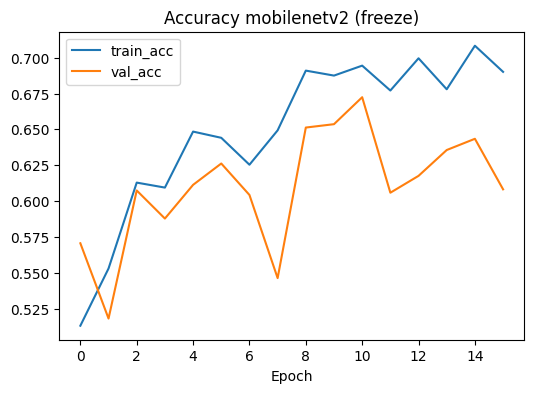

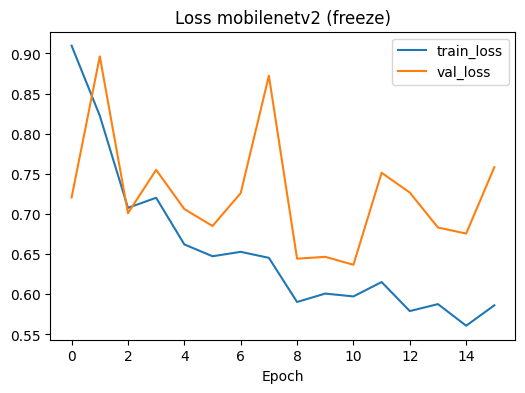

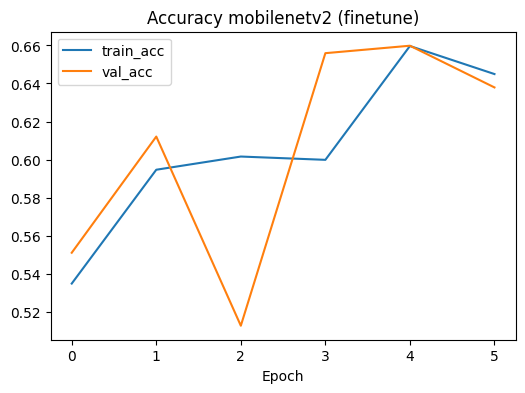

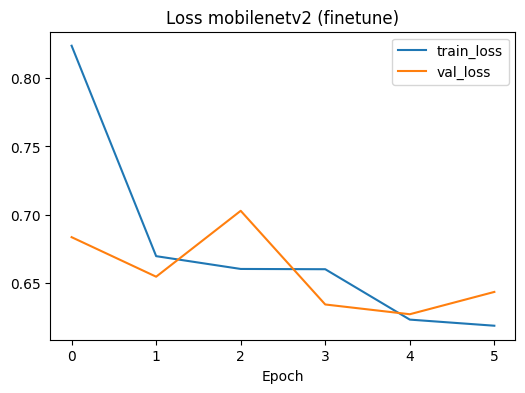

In [ ]:
for bb, (h1, h2) in histories.items():
    plot_history(h1, f"{bb} (freeze)")
    plot_history(h2, f"{bb} (finetune)")


=== Test: MOBILENETV2 ===
              precision    recall  f1-score   support

 oral_normal     0.7457    0.5233    0.6150       751
    oral_scc     0.6324    0.8213    0.7146       750

    accuracy                         0.6722      1501
   macro avg     0.6891    0.6723    0.6648      1501
weighted avg     0.6891    0.6722    0.6648      1501



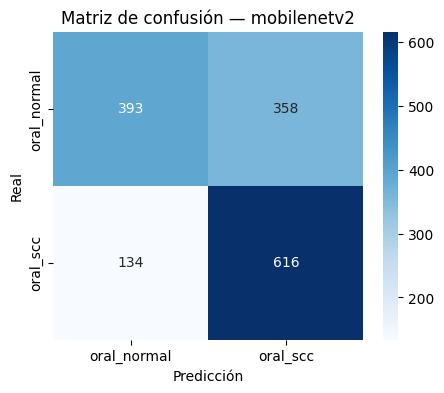

,backbone,test_accuracy,test_f1_macro
0,mobilenetv2,0.672219,0.66482


In [ ]:
# Cargar y evaluar mejores modelos guardados
from tensorflow import keras
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def predict_ds(model, ds):
    """
    Recorre un tf.data.Dataset (xb, yb) y devuelve:
      - y_true: etiquetas verdaderas como enteros
      - y_pred: clases predichas como enteros
    Asume que yb viene en one-hot.
    """
    y_true, y_pred = [], []
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)          # (batch, n_classes) probabilidades
        y_pred += list(np.argmax(probs, axis=1))      # índice de la clase con mayor prob.
        y_true += list(np.argmax(yb.numpy(), axis=1)) # convierte one-hot → índice entero
    return np.array(y_true), np.array(y_pred)

results = []  # acumularemos métricas por backbone

for bb in BACKBONES:
    print(f"\n=== Test: {bb.upper()} ===")

    # 1) Cargar el mejor checkpoint guardado durante entrenamiento
    best_path = best_paths[bb]
    m = keras.models.load_model(best_path, compile=False)  # evita problemas con Lambda/custom
    # recompilamos para evaluar; optimizador simple y pérdida estándar de clasificación
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # 2) Predicciones en test
    y_true, y_pred = predict_ds(m, test_ds)

    # 3) Métricas principales
    acc  = accuracy_score(y_true, y_pred)                 # exactitud global
    f1m  = f1_score(y_true, y_pred, average="macro")      # F1 macro (promedio por clase)

    # 4) Reporte detallado por clase
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

    # 5) Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues"
    )
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.title(f"Matriz de confusión — {bb}")
    plt.show()

    # 6) Guardar resumen en lista de resultados
    results.append({"backbone": bb, "test_accuracy": acc, "test_f1_macro": f1m})

# 7) Tabla con las métricas por backbone
pd.DataFrame(results)


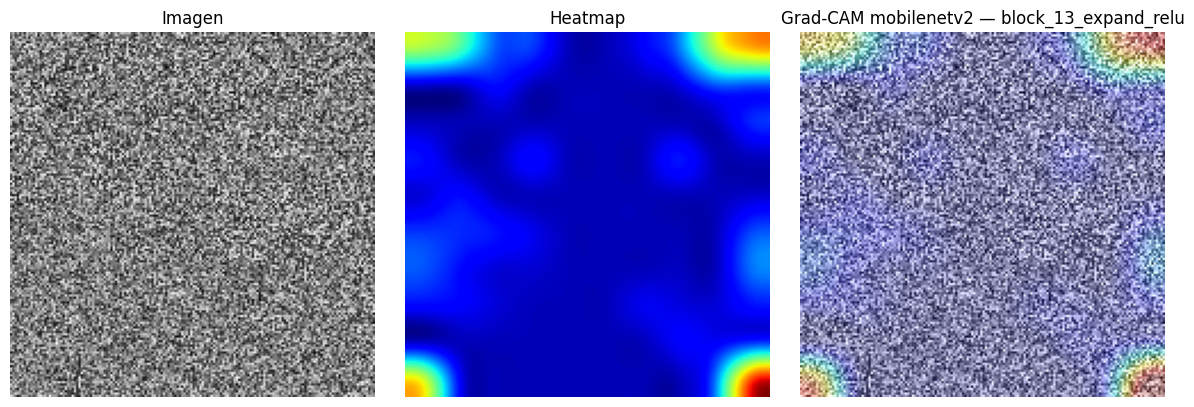

In [ ]:
sample_test_path = test_df["path"].iloc[0]
mdl = keras.models.load_model(best_paths["mobilenetv2"], compile=False)
mdl.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Capa con más detalle espacial y overlay suave:
show_gradcam_better(
    mdl, sample_test_path, backbone="mobilenetv2",
    preferred_layers=("block_13_expand_relu","block_14_expand_relu","Conv_1"),
    alpha=0.30, blur_ks=13, as_gray=True, title="Grad-CAM mobilenetv2"
)
